# Ray Mock Interview Answers

## Questions:
1. Given this dataset, how would you approach studying how interactive users are with this product?  What factors would you need to consider?

    A: Could say to look at how many times per day a user logs in, how long they are logged in, or how often they click (clicks per unit time). 

2. Let's focus on the case where we study how often a user clicks.  Can you write a function that takes in a username and software version, and returns clicks per (unit time)?

3. Run your function for each user and store each of their average number of clicks per (unit time).

4. How would you analyze which version of the software generates more user interaction?  Are you making any assumptions for this analysis?

    A: Should use, e.g., a t-test

5. Go ahead and perform this test.  Would you recommend the test build as an improvement over the original?  Why or why not?

In [1]:
import numpy as np
import pandas as pd
from user_info import save_users

In [2]:
# Generate a mock user dataset
save_users()

100%|██████████| 25132/25132 [00:06<00:00, 3977.89it/s]


## Read the data

In [3]:
filename = 'clickdata.csv'
df = pd.read_csv(filename)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df

,UID,timestamp,msg,version
0,4985,2020-03-21 15:17:42,Login,orig
1,2574,2020-03-21 15:21:53,Login,orig
2,7294,2020-03-21 15:24:38,Login,orig
3,9570,2020-03-21 15:25:24,Signal_Level_47,test
4,5685,2020-03-21 15:30:31,Signal_Level_09,test
...,...,...,...,...
357904,1894,2021-03-22 02:05:38,Logout,test
357905,4329,2021-03-22 02:05:47,record_click,test
357906,5788,2021-03-22 02:06:19,Logout,test
357907,4329,2021-03-22 02:10:21,Logout,test


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357909 entries, 0 to 357908
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UID        357909 non-null  int64         
 1   timestamp  357909 non-null  datetime64[ns]
 2   msg        357909 non-null  object        
 3   version    357909 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 10.9+ MB


In [6]:
messages = df.msg.unique().astype(str)
# print(messages)
messages_important = [m for m in messages if m[:-2] != 'Signal_Level_']
print('Important messages: ', messages_important)

Important messages:  ['Login', 'Logout', 'record_click']


In [7]:
df.version.unique()

array(['orig', 'test'], dtype=object)

In [8]:
# Clean the data
df_clean = df.query(f'msg in {messages_important}')

## Click rate

In [9]:
def calc_clicks_per_min(df, uid, version):
    '''
    Assumes the same number of logins and logouts and
    that each logout follows a login.
    '''
    userdata = df.query(f'UID=={uid} and version=={version!r}')
    userdata.reset_index(inplace=True)
    idx_login = userdata.query(f'msg=={"Login"!r}').index
    idx_logout = userdata.query(f'msg=={"Logout"!r}').index
    clickrate_list = []
    for ilin,ilout in zip(idx_login, idx_logout):
        time_login = userdata.iloc[ilin].timestamp.timestamp()
        time_logout = userdata.iloc[ilout].timestamp.timestamp()
        nclicks = ilout - ilin + 1
        clickrate_session = nclicks / (time_logout - time_login)
        clickrate_list.append(clickrate_session)
    clickrate = np.mean(clickrate_list) * 3600
    return clickrate

In [10]:
calc_clicks_per_min(df_clean, 4985, 'orig')

0.7563158791599855

## Comparing user click rates

In [11]:
users = df_clean.UID.unique()
print(f'{len(users)} users')
user_clicks_orig = np.array(
    [calc_clicks_per_min(df_clean, u, 'orig') for u in users])
user_clicks_test = np.array(
    [calc_clicks_per_min(df_clean, u, 'test') for u in users])

955 users


Some diagnostic info:

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

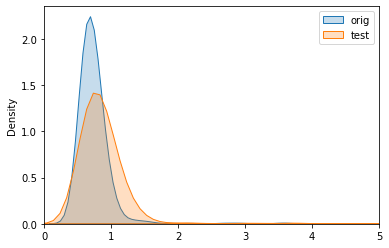

In [13]:
sns.kdeplot(user_clicks_orig, shade=True, label='orig')
sns.kdeplot(user_clicks_test, shade=True, label='test')
plt.xlim(0., 5.)
plt.legend()

In [14]:
print('Means:    ', user_clicks_orig.mean(), user_clicks_test.mean())
print('Std devs: ', user_clicks_orig.std(), user_clicks_test.std())

Means:     0.747722451152561 0.8743736675841907
Std devs:  0.41177610395251957 0.6819014555131065


### one-sided paired t-test
`alternative='less'` below makes it one-sided (null hypothesis is that argument 1 is less than argument 2).



In [15]:
from scipy.stats import ttest_rel

In [16]:
results = ttest_rel(user_clicks_orig, user_clicks_test, alternative='less')
print(f't = {results.statistic}')
print(f'p value = {results.pvalue}')

t = -4.885453154546841
p value = 6.048744321835903e-07


## Assumptions
- Logins precede logouts.
- The click rate uses the time between login and logout (rather than, e.g., the time between first and last click).
- Each user has used both the orig and test versions. (Otherwise, we would use an *unpaired* t-test.---I think this code mostly still works.)

## Recommendation

(Assuming that the click rate is actually a good metric for interactivity,) I would recommend the test build. The p-value is extremely small.